In [2]:
from custom_models.cnn import CNN
from custom_models.mlp import MLP
from vit_pytorch import ViT
from helper_methods import get_data_loaders
from pipeline import CustomModelPipeline
from torch import optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import torch
import pandas as pd


# set seaborn style
sns.set_theme(
    context="notebook", style="whitegrid", palette="bright", color_codes=True, rc=None
)

In [3]:
# Experiment repetitions
N_REPEATS = 5

# Training config
N_EPOCHS = 50
DATA_AUG_TRAIN = False


#Model Hyperparameters
LOSS_FN = nn.CrossEntropyLoss()
OPTIMIZER_CLASS = optim.Adam
LR = 0.0005


# Early Stopping Configuration
ES_PATIENCE = 50
MIN_ES_DELTA = 0.001

In [ ]:
def get_class_weights(train_loader, n_classes):
    """Calculate class weights for imbalanced dataset"""
    # Get the number of samples in each class
    class_counts = np.zeros(n_classes)
    for _, labels in train_loader:
        for label in labels:
            class_counts[label.item()] += 1

    # Calculate the weights
    total_samples = sum(class_counts)
    class_weights = total_samples / (n_classes * class_counts)

    # Ensure weights tensor has correct shape and is of expected type
    return torch.tensor(class_weights, dtype=torch.float).to(
        "cuda" if torch.cuda.is_available() else "cpu"
    )


def init_pipeline(
    train_loader,
    validation_loader,
    train_loader_at_eval,
    test_loader,
    input_size,
    num_classes,
    patience=ES_PATIENCE,  # Add patience parameter
):
    """Initialize pipeline with MLP model"""
    # Initialize MLP with proper parameters
    model = ViT(
        image_size=28,  # DermaMNIST images are 28×28
        patch_size=4,  # Smaller patch size works well for MNIST-type datasets
        num_classes=7,  # DermaMNIST has 7 classes
        dim=128,  # Smaller embedding dimension
        depth=8,  # Fewer transformer layers
        heads=8,  # Fewer attention heads
        mlp_dim=1024,  # Smaller MLP dimension
        dropout=0.2,
        emb_dropout=0,
    )

    # CNN()

    # MLP(
    #    input_size=input_size, num_classes=num_classes, hidden_sizes=(1024, 256)
    # )

    pipeline = CustomModelPipeline(
        model=model,
        criterion=LOSS_FN,
        min_delta=MIN_ES_DELTA,
        optimizer_class=OPTIMIZER_CLASS,
        optimizer_params={
            "lr": LR,
        },
        n_epochs=N_EPOCHS,
        training_data=train_loader,
        validation_data=validation_loader,
        test_data=test_loader,
        patience=patience,  # Pass patience parameter
        device="cuda" if torch.cuda.is_available() else "cpu",
    )
    return pipeline


(
    train_loader,
    train_loader_at_eval,
    test_loader,
    validation_loader,
    n_channels,
    n_classes,
    task,
    pil_dataset,
) = get_data_loaders(data_augmentation=DATA_AUG_TRAIN)


print(get_class_weights(train_loader, n_classes))

# first sample
sample = next(iter(train_loader))
print(f"Sample Shape: {sample[0].shape}")

# No of Neurons in Input Layer
# Output is flattened before feeding to MLP
input_size = n_channels * sample[0].shape[2] * sample[0].shape[3]

# No of Neurons in Output Layer
num_classes = n_classes

print(f"Input size: {input_size}, Number of classes: {num_classes}")

accuracies = []
f1_scores = []
t_losses = []
v_losses = []
t_durations = []
roc_auc_micro = []
roc_auc_macro = []
fprs_micro = []
tprs_micro = []
cf_matrixes = []
roc_auc_per_class = [[] for _ in range(num_classes)]


# Create and execute pipelines for each repeat
for i in range(N_REPEATS):
    print(f"Repeat {i + 1}/{N_REPEATS}")
    pipeline = init_pipeline(
        train_loader,
        validation_loader,
        train_loader_at_eval,
        test_loader,
        input_size,
        num_classes,
    )

    # train on training data and eval on unseen test data
    pipeline.execute_and_test()

    # get scores on test data
    scores = pipeline.get_test_scores()
    accuracies.append(scores["accuracy"])
    f1_scores.append(scores["f1"])
    roc_auc_micro.append(scores["roc_auc"]["micro"])
    roc_auc_macro.append(scores["roc_auc"]["macro"])
    for i in range(num_classes):
        roc_auc_per_class[i].append(scores["roc_auc"][i])
    fprs_micro.append(scores["fpr"]["micro"])
    tprs_micro.append(scores["tpr"]["micro"])
    cf_matrixes.append(scores["confusion_matrix"])

    losses = pipeline.get_losses()
    t_losses.append(losses["train"])
    v_losses.append(losses["val"])

    t_durations.append(pipeline.get_run_duration())

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
tensor([ 4.3904,  2.7883,  1.3017, 12.5125,  1.2850,  0.2133, 10.1111],
       device='cuda:0')
Sample Shape: torch.Size([128, 3, 28, 28])
Input size: 2352, Number of classes: 7
Repeat 1/5
Using device: cuda
Starting training for 50 epochs...
Epoch 1/50 - Train Loss: 1.1226, Val Loss: 1.0281
Epoch 2/50 - Train Loss: 1.0093, Val Loss: 0.9978
Epoch 3/50 - Train Loss: 0.9740, Val Loss: 0.8983
Epoch 4/50 - Train Loss: 0.8853, Val Loss: 0.8342
Epoch 5/50 - Train Loss: 0.8123, Val Loss: 0.7724
Epoch 6/50 - Train Loss: 0.7764, Val Loss: 0.7489
Epoch 7/50 - Train Loss: 0.7507, Val Loss: 0.7369
Epoch 8/50 - Train Loss: 0.7266, Val Loss: 0.72

In [5]:
# From: https://stackoverflow.com/a/15034143
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mci_accuracy = mean_confidence_interval(accuracies)
mci_f1 = mean_confidence_interval(f1_scores)
mci_training_duration = mean_confidence_interval(t_durations)

# Mean +- CI
print(f"Accuracy: {mci_accuracy[0]:.4f} +- {(mci_accuracy[2] - mci_accuracy[0]):.4f}")
print(f"({mci_accuracy[1]:.4f}, {mci_accuracy[2]:.4f})")
print(f"F1 Score: {mci_f1[0]:.4f} +- {(mci_f1[2] - mci_f1[0]):.4f}")
print(f"({mci_f1[1]:.4f}, {mci_f1[2]:.4f})")
print(f"ROC AUC Micro: {np.mean(roc_auc_micro):.4f} +- {(np.std(roc_auc_micro)):.4f}")
print(f"ROC AUC Macro: {np.mean(roc_auc_macro):.4f} +- {(np.std(roc_auc_macro)):.4f}")


# Training Duration
print(f"Training Duration: {mci_training_duration[0]:.4f} +- {(mci_training_duration[2] - mci_training_duration[0]):.4f}")
print(f"({mci_training_duration[1]:.4f}, {mci_training_duration[2]:.4f})")



Accuracy: 0.7365 +- 0.0055
(0.7309, 0.7420)
F1 Score: 0.4456 +- 0.0255
(0.4200, 0.4711)
ROC AUC Micro: 0.9471 +- 0.0039
ROC AUC Macro: 0.8717 +- 0.0138
Training Duration: 482.3256 +- 6.0736
(476.2520, 488.3991)


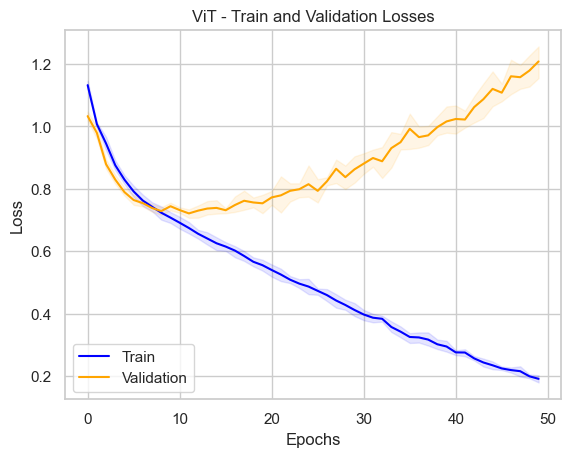

In [ ]:
from helper_methods import plot_avg_losses

plot_avg_losses(t_losses, v_losses)

<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:66: SyntaxWarning: invalid escape sequence '\p'
C:\Users\josem\AppData\Local\Temp\ipykernel_28972\4167443583.py:45: SyntaxWarning: invalid escape sequence '\p'
  label_str += f" $\pm$ {std_dev_aucs[i]:.3f}"
C:\Users\josem\AppData\Local\Temp\ipykernel_28972\4167443583.py:66: SyntaxWarning: invalid escape sequence '\p'
  label_str += f' $\pm$ {std_dev_aucs["micro"]:.3f}'


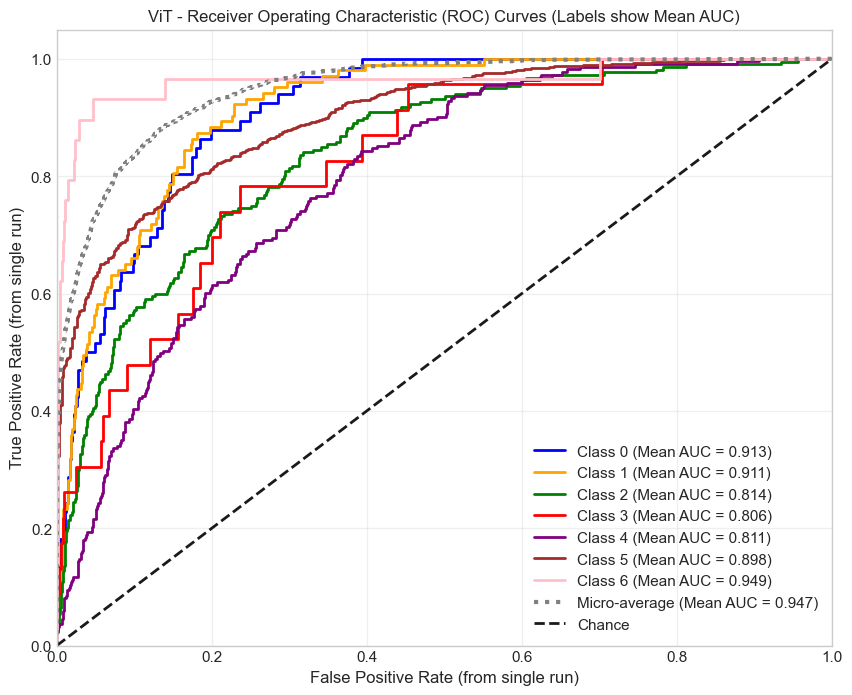

In [ ]:
# Code developed with the help of Claude Sonnet 3.7
def plot_roc_auc_curves_with_mean_labels(
    pipeline_results, mean_aucs, std_dev_aucs=None
):
    """
    Plots ROC curves from a SINGLE run, but labels them with MEAN AUC values
    calculated from MULTIPLE runs.

    Parameters:
    -----------
    pipeline_results : Object
        The pipeline object AFTER running execute_and_test() for ONE representative run.
        Used to get the actual FPR/TPR curve shapes.
    mean_aucs : dict
        Dictionary containing the MEAN AUC values for each class (e.g., 0, 1, ...)
        and 'micro', calculated across multiple runs.
    std_dev_aucs : dict, optional
        Dictionary containing the standard deviation of the AUC values for each class
        and 'micro', calculated across multiple runs. If provided, adds (+- std) to label.
    """
    import matplotlib.pyplot as plt
    import numpy as np

    plt.style.use("seaborn-v0_8-whitegrid")  # Example style
    plt.figure(figsize=(10, 8))

    colors = ["blue", "orange", "green", "red", "purple", "brown", "pink"]

    # Get the test scores FROM THE SINGLE RUN (for curve shape)
    scores = pipeline_results.get_test_scores()

    # --- Plot ROC curve for each class ---
    num_classes = (
        len(mean_aucs) - 1 if "micro" in mean_aucs else len(mean_aucs)
    )  # Infer number of classes
    if "macro" in mean_aucs:
        num_classes -= 1  # Adjust if macro is also present but not plotted per class

    for i in range(num_classes):
        # Use FPR/TPR from the single run's scores
        if i in scores["fpr"] and i in scores["tpr"]:
            # *** Use MEAN AUC (and optional STD DEV) for the LABEL ***
            label_auc = mean_aucs.get(i, float("nan"))  # Get mean AUC for class i
            label_str = f"Class {i} (Mean AUC = {label_auc:.3f}"
            if std_dev_aucs and i in std_dev_aucs:
                label_str += f" $\pm$ {std_dev_aucs[i]:.3f}"
            label_str += ")"

            plt.plot(
                scores["fpr"][i],
                scores["tpr"][i],
                color=colors[i % len(colors)],
                lw=2,
                label=label_str,
            )
        else:
            print(
                f"Warning: No FPR/TPR data found for class {i} in the provided pipeline_results."
            )

    # --- Plot micro-average ROC curve ---
    if "micro" in scores["fpr"] and "micro" in scores["tpr"]:
        # *** Use MEAN Micro AUC (and optional STD DEV) for the LABEL ***
        label_auc = mean_aucs.get("micro", float("nan"))
        label_str = f"Micro-average (Mean AUC = {label_auc:.3f}"
        if std_dev_aucs and "micro" in std_dev_aucs:
            label_str += f' $\pm$ {std_dev_aucs["micro"]:.3f}'
        label_str += ")"

        plt.plot(
            scores["fpr"]["micro"],
            scores["tpr"]["micro"],
            label=label_str,
            color="gray",
            linestyle=":",
            linewidth=3,
        )
    else:
        print(
            f"Warning: No micro-average FPR/TPR data found in the provided pipeline_results."
        )

    # Plot the random chance line
    plt.plot([0, 1], [0, 1], "k--", lw=2, label="Chance")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate (from single run)")
    plt.ylabel("True Positive Rate (from single run)")
    plt.title(
        "ViT - Receiver Operating Characteristic (ROC) Curves (Labels show Mean AUC)"
    )
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()



mean_aucs = {i: np.mean(roc_auc_per_class[i]) for i in range(num_classes)}
mean_aucs["micro"] = np.mean(roc_auc_micro)
mean_aucs["macro"] = np.mean(roc_auc_macro)



plot_roc_auc_curves_with_mean_labels(pipeline, mean_aucs, std_dev_aucs=None)

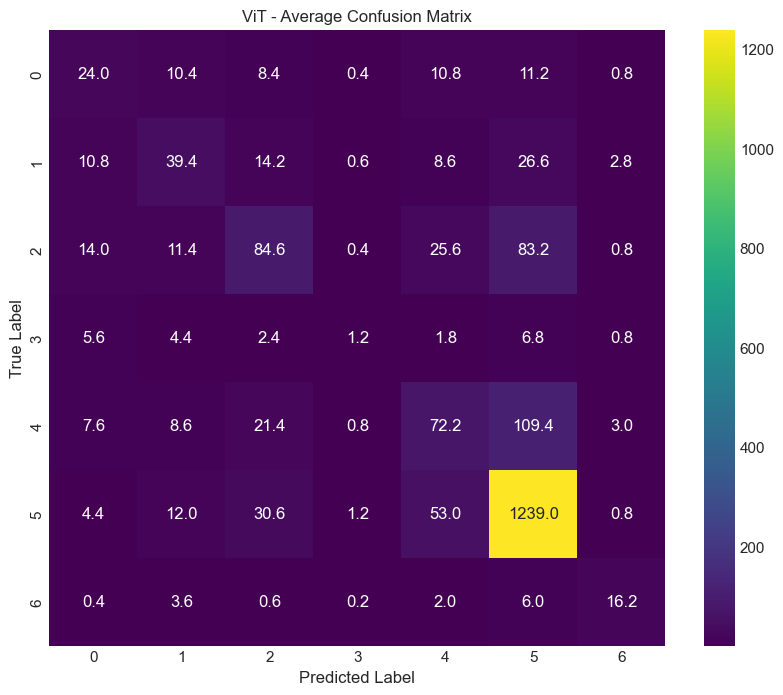

In [ ]:
# Plot average confusion matrix


def plot_avg_confusion_matrix(cf_matrixes, n_classes):
    # Calculate the mean and standard deviation of the confusion matrices
    avg_cf_matrix = np.mean(cf_matrixes, axis=0)
    std_cf_matrix = np.std(cf_matrixes, axis=0)

    cf_df = pd.DataFrame(
        avg_cf_matrix, index=range(n_classes), columns=range(n_classes)
    )

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cf_df,
        annot=True,
        fmt=".1f",
        square=True,
        cmap="viridis",
        xticklabels=range(n_classes),
        yticklabels=range(n_classes),
        
    )

    plt.title("ViT - Average Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


plot_avg_confusion_matrix(cf_matrixes, n_classes)